In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report


In [2]:
# Step 1: Load and Review dataset 
df = pd.read_csv("customer_churn_raw.csv")

df.head() # quick glance


,customer_id,region,tenure_months,monthly_charges,contract_type,internet_type,payment_method,support_tickets_90d,num_logins_30d,late_payments_12m,age,is_senior,churn
0,100000,West,24,64.68,one_year,fiber,mailed_check,3,18,0,22,0,0
1,100001,South,15,40.69,one_year,fiber,paypal,1,16,0,22,0,1
2,100002,West,37,61.60,two_year,dsl,paypal,0,19,1,34,0,1
3,100003,East,47,46.26,month_to_month,fiber,credit_card,1,26,1,47,0,1
4,100004,North,18,59.45,one_year,fiber,paypal,0,17,1,32,0,0


In [3]:
df.info() # quick summary 
df.describe() #descriptive stats of dataset
df.isna().sum() # Missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          5000 non-null   int64  
 1   region               5000 non-null   object 
 2   tenure_months        5000 non-null   int64  
 3   monthly_charges      4949 non-null   float64
 4   contract_type        5000 non-null   object 
 5   internet_type        5000 non-null   object 
 6   payment_method       5000 non-null   object 
 7   support_tickets_90d  5000 non-null   int64  
 8   num_logins_30d       5000 non-null   int64  
 9   late_payments_12m    5000 non-null   int64  
 10  age                  5000 non-null   int64  
 11  is_senior            5000 non-null   int64  
 12  churn                5000 non-null   int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 507.9+ KB


customer_id             0
region                  0
tenure_months           0
monthly_charges        51
contract_type           0
internet_type           0
payment_method          0
support_tickets_90d     0
num_logins_30d          0
late_payments_12m       0
age                     0
is_senior               0
churn                   0
dtype: int64

In [4]:
# Step 2.1: Clean dataset and create a new df from raw df 

# Convert to numeric (blanks will turn into NaN)
df["monthly_charges"] = pd.to_numeric(df["monthly_charges"], errors="coerce")

# Check missing after conversion
df["monthly_charges"].isna().sum()

# Fill missing with median (more robust than mean)
df.fillna({"monthly_charges": df["monthly_charges"].median()}, inplace=True)

# Clean contract_type
# Strip whitespace
df["contract_type"] = df["contract_type"].str.strip()

df.head()

,customer_id,region,tenure_months,monthly_charges,contract_type,internet_type,payment_method,support_tickets_90d,num_logins_30d,late_payments_12m,age,is_senior,churn
0,100000,West,24,64.68,one_year,fiber,mailed_check,3,18,0,22,0,0
1,100001,South,15,40.69,one_year,fiber,paypal,1,16,0,22,0,1
2,100002,West,37,61.60,two_year,dsl,paypal,0,19,1,34,0,1
3,100003,East,47,46.26,month_to_month,fiber,credit_card,1,26,1,47,0,1
4,100004,North,18,59.45,one_year,fiber,paypal,0,17,1,32,0,0


In [5]:
 # Quick check of categories
for col in ["contract_type", "internet_type", "payment_method", "region"]:
    print(col, ":", df[col].unique())
 

contract_type : ['one_year' 'two_year' 'month_to_month']
internet_type : ['fiber' 'dsl' 'none']
payment_method : ['mailed_check' 'paypal' 'credit_card' 'bank_transfer']
region : ['West' 'South' 'East' 'North']


In [6]:
# missing values
# General missing check
df.isna().sum()


customer_id            0
region                 0
tenure_months          0
monthly_charges        0
contract_type          0
internet_type          0
payment_method         0
support_tickets_90d    0
num_logins_30d         0
late_payments_12m      0
age                    0
is_senior              0
churn                  0
dtype: int64

In [7]:
# encode target
df["churn"].value_counts(normalize=True)


churn
1    0.5452
0    0.4548
Name: proportion, dtype: float64

In [8]:
#Clean copy
df.to_csv("customer_churn_clean.csv", index=False)


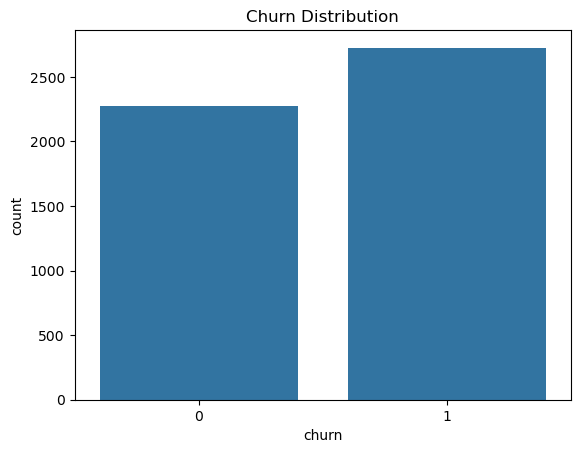

Chrun Rate: 0.5452


In [9]:
# Section 3.1: EDA (Descriptive Statitics) 

# Understand the target distribution 0 = false and 1 = true 
sns.countplot(x="churn", data=df)
plt.title("Churn Distribution")
plt.show()

print("Chrun Rate:", df["churn"].mean())

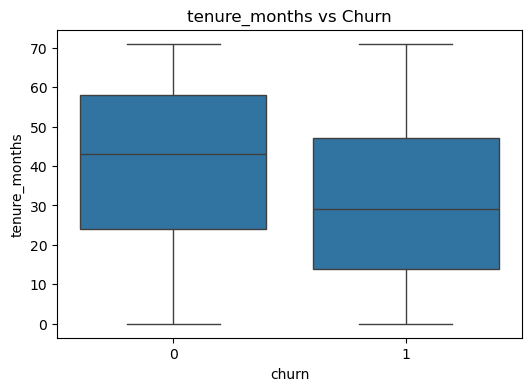

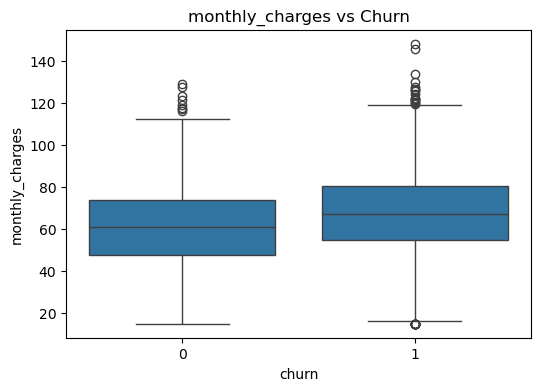

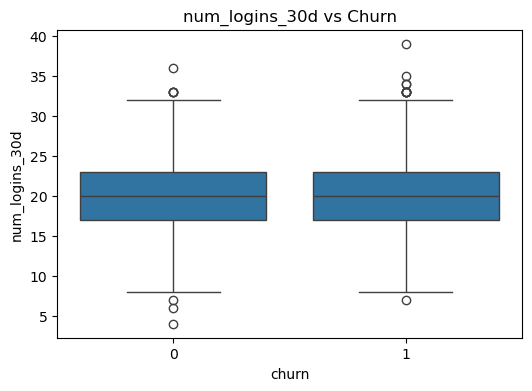

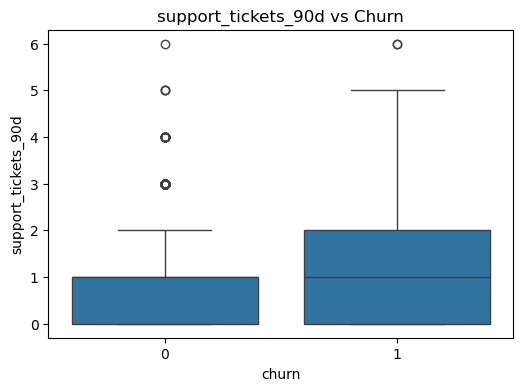

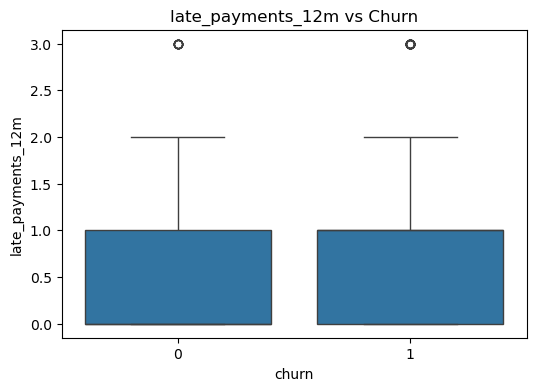

In [10]:
# Section 3.2: Numeric features vs chrun 
num_cols = ["tenure_months", "monthly_charges", "num_logins_30d", "support_tickets_90d", "late_payments_12m"]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="churn", y=col, data=df)
    plt.title(f"{col} vs Churn")
    plt.show()


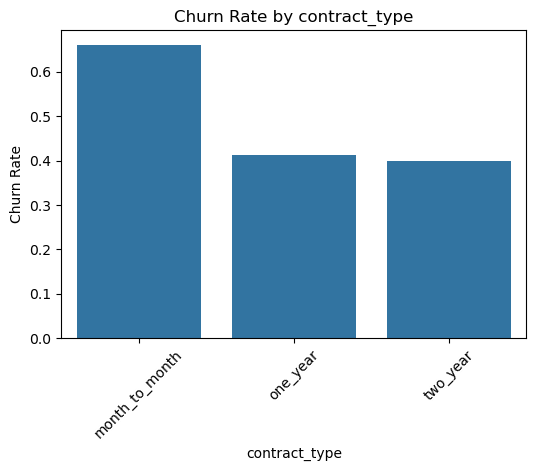

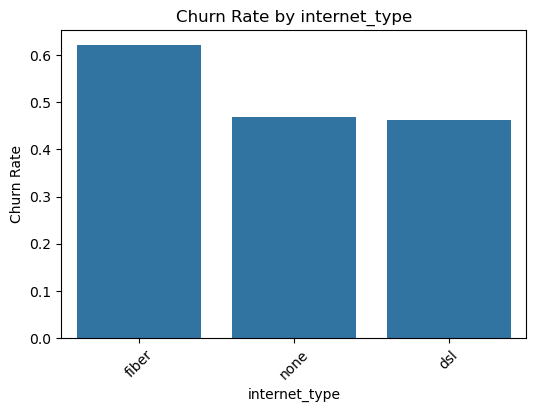

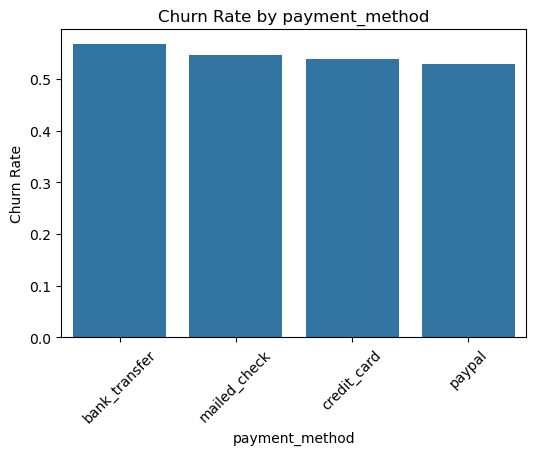

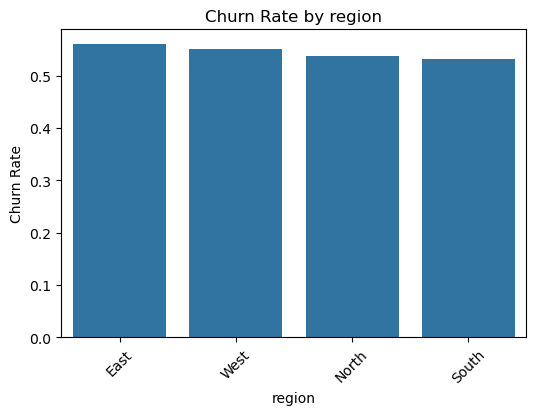

In [11]:
# Section 3.3 Categorical features vs churn 
cat_cols = ["contract_type", "internet_type", "payment_method", "region"]

for col in cat_cols:
    plt.figure(figsize=(6,4))
    churn_rate = df.groupby(col)["churn"].mean().sort_values(ascending=False)
    sns.barplot(x=churn_rate.index, y=churn_rate.values)
    plt.title(f"Churn Rate by {col}")
    plt.ylabel("Churn Rate")
    plt.xticks(rotation=45)
    plt.show()


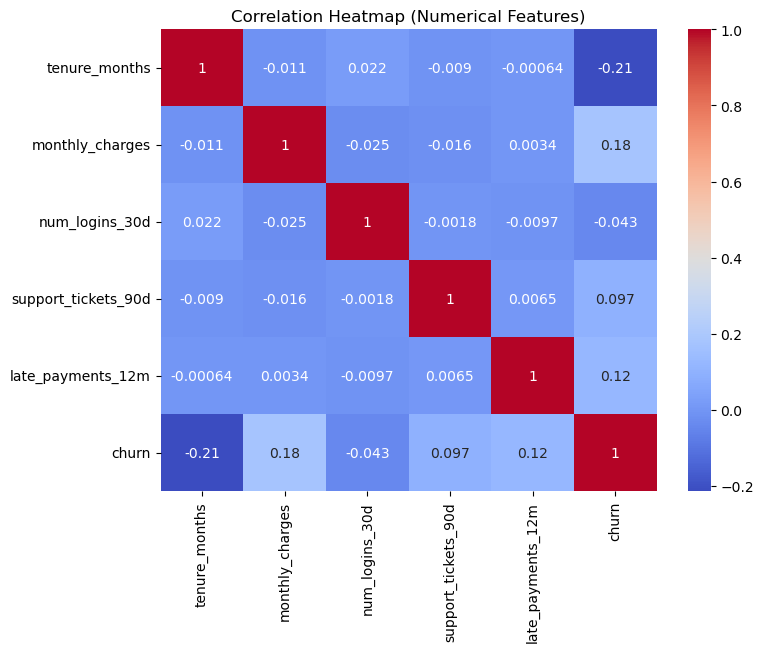

In [12]:
# Section 3.4 correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols + ["churn"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


In [13]:
# Section 4.1: Fetaure Engineering and Modeling 
# Separate features (X) and target (y)
X = df.drop(columns=["churn", "customer_id"])  # remove target + unique ID
y = df["churn"]

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (4000, 11)
Test shape: (1000, 11)


In [14]:
# 4.2 Preprocessing 


num_cols = ["tenure_months", "monthly_charges", "num_logins_30d", "support_tickets_90d", "late_payments_12m", "age"]
cat_cols = ["contract_type", "internet_type", "payment_method", "region"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])


In [15]:
# 4.3 Baseline Model (Logistic Regression) 

# Build pipeline
log_reg = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

# Train
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


Accuracy: 0.687
ROC-AUC: 0.7478576469402157
              precision    recall  f1-score   support

           0       0.67      0.62      0.64       455
           1       0.70      0.74      0.72       545

    accuracy                           0.69      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.69      0.69      0.69      1000



In [17]:
# Section 5.1: Train Tree Model (RandomForest) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
])

rf.fit(X_train, y_train)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("ROC-AUC (RandomForest):", roc_auc_score(y_test, y_prob_rf))





ROC-AUC (RandomForest): 0.705363443895554


In [18]:
# Section 5.2: # Global importances (tree models)
rf_importance = rf.named_steps["clf"].feature_importances_
feat_names = rf.named_steps["pre"].get_feature_names_out()

import pandas as pd
imp = pd.DataFrame({"feature": feat_names, "importance": rf_importance}).sort_values("importance", ascending=False)
imp.head(15)

# Model-agnostic permutation importance
from sklearn.inspection import permutation_importance
X_test_t = rf.named_steps["pre"].transform(X_test)
result = permutation_importance(rf.named_steps["clf"], X_test_t, y_test, n_repeats=10, random_state=42)
perm = pd.DataFrame({"feature": feat_names, "importance": result.importances_mean}).sort_values("importance", ascending=False)
perm.head(15)


,feature,importance
0,num__tenure_months,0.0393
1,num__monthly_charges,0.0325
6,cat__contract_type_month_to_month,0.0300
7,cat__contract_type_one_year,0.0145
10,cat__internet_type_fiber,0.0124
3,num__support_tickets_90d,0.0119
5,num__age,0.0107
2,num__num_logins_30d,0.0082
17,cat__region_North,0.0058
14,cat__payment_method_mailed_check,0.0047


In [19]:
# Section 6.1 : Compute probability scores and core metrics (ROC/PR AUC)
# ------------------------------------------------------------
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Model posterior probabilities for the positive class (churn=1)
y_prob = rf.predict_proba(X_test)[:, 1]

# Area-under-ROC: how well scores separate churners vs non-churners overall
roc_auc = roc_auc_score(y_test, y_prob)

# Area-under-PR: robust when classes are imbalanced (focuses on positive class quality)
pr_auc = average_precision_score(y_test, y_prob)

print(f"ROC-AUC: {roc_auc:.3f}")
print(f"PR-AUC:  {pr_auc:.3f}")



ROC-AUC: 0.705
PR-AUC:  0.724


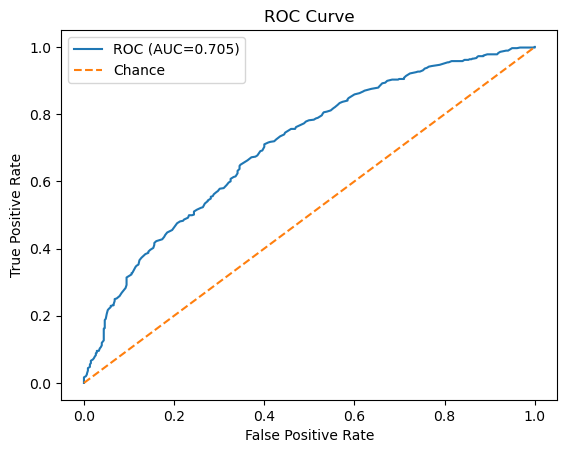

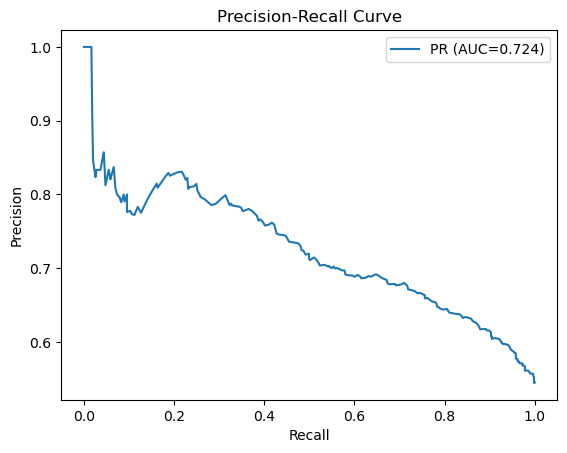

In [20]:
# 6.2 Plot ROC and Precision-Recall
# -------------------------------
fpr, tpr, thr = roc_curve(y_test, y_prob)
plt.figure(); plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})"); plt.plot([0,1],[0,1],'--', label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve"); plt.legend(); plt.show()

prec, rec, thr2 = precision_recall_curve(y_test, y_prob)
plt.figure(); plt.plot(rec, prec, label=f"PR (AUC={pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend(); plt.show()


In [21]:

# 6.3 Choose an operating threshold based on business capacity (top 10%)
# ---------------------------------------------------------------------
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Business sets capacity to act on ~10% of customers each cycle (top-decile strategy)
cutoff = np.quantile(y_prob, 0.90)

# Convert probabilities to binary decisions using the chosen cutoff
y_pred_topdec = (y_prob >= cutoff).astype(int)

# Confusion matrix and precision/recall at this operating point
cm = confusion_matrix(y_test, y_pred_topdec)
prec_at_cap, rec_at_cap, f1_at_cap, _ = precision_recall_fscore_support(y_test, y_pred_topdec, average="binary")

print("Threshold (top 10%):", float(cutoff))
print("Confusion Matrix:\n", cm)
print(f"Precision: {prec_at_cap:.3f}  Recall: {rec_at_cap:.3f}  F1: {f1_at_cap:.3f}")


Threshold (top 10%): 0.8303333333333334
Confusion Matrix:
 [[435  20]
 [465  80]]
Precision: 0.800  Recall: 0.147  F1: 0.248


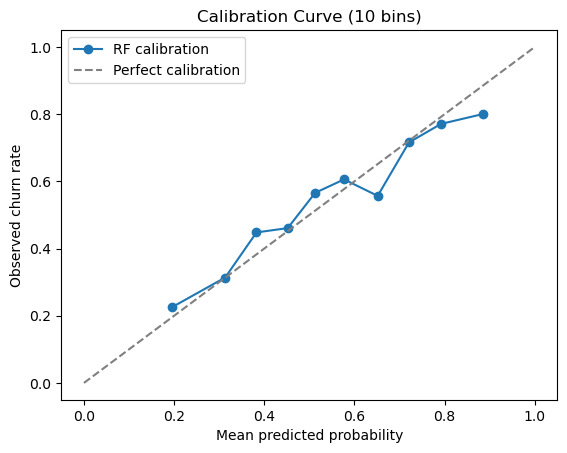

In [22]:
# 7.1: Calibration and lift -- Calibration curve: do predicted risks match reality?

from sklearn.calibration import calibration_curve

# Quantile strategy makes bins with similar counts (good for imbalanced data)
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="quantile")

plt.figure()
plt.plot(prob_pred, prob_true, marker="o", label="RF calibration")
plt.plot([0,1], [0,1], "--", color="gray", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed churn rate")
plt.title("Calibration Curve (10 bins)")
plt.legend()
plt.show()


In [23]:
# 7.2 Gains / Lift by decile: business-friendly targeting
# -------------------------------------------------------
import pandas as pd

# Build table sorted by descending risk
tmp = pd.DataFrame({"y": y_test, "p": y_prob}).sort_values("p", ascending=False).reset_index(drop=True)

# Split into 10 deciles (9=top risk ... 0=lowest)
tmp["decile"] = pd.qcut(tmp["p"], 10, labels=False, duplicates="drop")

# Compute churn rate and counts per decile (higher decile => higher churn expected)
lift = tmp.groupby("decile").agg(churn_rate=("y","mean"), count=("y","size")).sort_index(ascending=False)

# Cumulative captured churners by decile (how many churners you catch if you take top N deciles)
tmp["cum_churners"] = tmp["y"].cumsum()
# Map the max cumulative churners within each decile block (descending order)
cum_by_dec = tmp.groupby("decile")["cum_churners"].max().sort_index(ascending=False)
lift["cum_churners"] = cum_by_dec.values

lift.reset_index(drop=False, inplace=True)
lift.rename(columns={"decile":"risk_decile (9 highest)"}, inplace=True)
lift


,risk_decile (9 highest),churn_rate,count,cum_churners
0,9,0.800000,100,80
1,8,0.770833,96,154
2,7,0.715686,102,227
3,6,0.556701,97,281
4,5,0.605769,104,344
5,4,0.565657,99,400
6,3,0.460784,102,447
7,2,0.447917,96,490
8,1,0.313725,102,522
9,0,0.225490,102,545


In [32]:

# 8.1 Save the trained pipeline (model + preprocessing) 
# ------------------------------------------------------------
import os, joblib

# Ensure the 'models' folder exists
os.makedirs("../models", exist_ok=True)

# Save the RandomForest pipeline to disk
joblib.dump(rf, "../models/churn_model.pkl")

print("✅ Model saved to ../models/churn_model.pkl")




✅ Model saved to ../models/churn_model.pkl


In [33]:

# 8.2 Batch scorer: create an outreach action list (top 10%)
# -------------------------------------------------------------
import os
import numpy as np
import pandas as pd

# 1) Ensure the 'data' folder exists so saving won't fail
os.makedirs("../data", exist_ok=True)

def score_df(model, X: pd.DataFrame, top_frac: float = 0.10) -> pd.DataFrame:
    """
    Score a feature DataFrame with a sklearn pipeline and return the top fraction by risk.
    - model: a fitted sklearn Pipeline (preprocessor + classifier)
    - X: feature DataFrame used for scoring (same columns as training)
    - top_frac: fraction of rows to keep based on highest churn risk
    Returns a copy of X with an added 'churn_score' column, sorted descending.
    """
    proba = model.predict_proba(X)[:, 1]
    out = X.copy()
    out["churn_score"] = proba
    out = out.sort_values("churn_score", ascending=False)
    k = max(1, int(top_frac * len(out)))  # number of rows to keep
    return out.head(k)

# 2) Score the held-out test set with your trained pipeline (rf)
y_prob_test = rf.predict_proba(X_test)[:, 1]  # keep if you want metrics elsewhere
topk = score_df(rf, X_test, top_frac=0.10)

# 3) (Optional) If you have a raw test frame with identifiers, merge them back in for business readability
#    Create X_test_raw alongside your split earlier if you want IDs in the export, e.g.:
#    X_train_raw, X_test_raw, y_train, y_test = train_test_split(df.drop("churn", axis=1), y, ...)
#    Below we only merge if a customer_id exists.
try:
    # If you have X_test_raw in memory and it contains 'customer_id', align on index
    if "X_test_raw" in globals() and isinstance(X_test_raw, pd.DataFrame) and "customer_id" in X_test_raw.columns:
        # Align indices (assumes you derived X_test from X_test_raw with same row order)
        topk = topk.join(X_test_raw.loc[topk.index, ["customer_id"]])
        # Put ID first for readability
        cols = ["customer_id"] + [c for c in topk.columns if c != "customer_id"]
        topk = topk[cols]
except Exception as e:
    print("Note: could not attach customer_id; continuing without it. Reason:", e)

# 4) Keep a business-friendly subset of columns in the export
cols_for_business = [
    *(["customer_id"] if "customer_id" in topk.columns else []),
    "churn_score",
    # add key drivers your stakeholders recognize
    "contract_type", "tenure_months", "monthly_charges",
    "support_tickets_90d", "num_logins_30d", "region"
]
cols_for_business = [c for c in cols_for_business if c in topk.columns]  # guard if any missing

outreach = topk[cols_for_business].copy()

# 5) Save the outreach file
output_path = "../data/churn_outreach_top10pct.csv"
outreach.to_csv(output_path, index=False)

print(f"✅ Exported outreach file to {output_path}")
print(f"Rows: {len(outreach)} (top 10% of test set)")
outreach.head(10)


✅ Exported outreach file to ../data/churn_outreach_top10pct.csv
Rows: 100 (top 10% of test set)


,churn_score,contract_type,tenure_months,monthly_charges,support_tickets_90d,num_logins_30d,region
839,0.976667,month_to_month,25,71.99,0,14,East
3972,0.970000,month_to_month,13,75.87,1,18,East
459,0.960000,month_to_month,16,63.16,2,13,East
4064,0.953333,month_to_month,19,94.95,0,14,North
2727,0.950000,month_to_month,9,75.09,1,21,North
3362,0.946667,month_to_month,10,73.78,2,23,East
1496,0.946667,month_to_month,29,102.67,2,26,West
1246,0.943333,month_to_month,11,87.07,1,20,East
1739,0.940000,month_to_month,14,74.04,1,24,West
1524,0.933333,month_to_month,24,75.52,1,20,East


In [34]:

# 8.3 Reason codes (simple fallback without SHAP): human-friendly field highlights
# --------------------------------------------------------------------------------
# Use permutation importance to identify globally influential features,
# then surface the corresponding raw field values for each customer in the outreach file.

from sklearn.inspection import permutation_importance

# Transform features once (preprocessor lives in pipeline)
pre = rf.named_steps["pre"]
clf = rf.named_steps["clf"]
feat_names = pre.get_feature_names_out()
X_test_t = pre.transform(X_test)

# Model-agnostic permutation importance (robust explanation signal)
result = permutation_importance(clf, X_test_t, y_test, n_repeats=10, random_state=42)
perm = pd.DataFrame({"feature": feat_names, "importance": result.importances_mean}).sort_values("importance", ascending=False)

# Pick top raw-feature families to show (readable for business)
cols_to_show = ["contract_type","tenure_months","monthly_charges","support_tickets_90d","num_logins_30d"]

# Merge readable reasons into outreach list
action = topk.copy()
action["top_reasons"] = action[cols_to_show].astype(str).agg("; ".join, axis=1)
action_out = action[["churn_score"] + cols_to_show + ["top_reasons"]]

action_out.head(5)


,churn_score,contract_type,tenure_months,monthly_charges,support_tickets_90d,num_logins_30d,top_reasons
839,0.976667,month_to_month,25,71.99,0,14,month_to_month; 25; 71.99; 0; 14
3972,0.970000,month_to_month,13,75.87,1,18,month_to_month; 13; 75.87; 1; 18
459,0.960000,month_to_month,16,63.16,2,13,month_to_month; 16; 63.16; 2; 13
4064,0.953333,month_to_month,19,94.95,0,14,month_to_month; 19; 94.95; 0; 14
2727,0.950000,month_to_month,9,75.09,1,21,month_to_month; 9; 75.09; 1; 21


In [43]:
import os, joblib, pathlib

# Ensure ./models exists next to your notebook/app
root = pathlib.Path(r"C:\Users\Adib1\OneDrive\Documents\Python Data Science\Python DS Projects\Customer Churn Prediction")
models_dir = root / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# Save the trained pipeline here:
model_path = models_dir / "churn_model.pkl"
joblib.dump(rf, model_path)

print(f"✅ Saved model to: {model_path}")




✅ Saved model to: C:\Users\Adib1\OneDrive\Documents\Python Data Science\Python DS Projects\Customer Churn Prediction\models\churn_model.pkl


In [44]:
# create app.py from pathlib import Path
import shutil, datetime

# 1) Point to your project root and app.py
root = Path(r"C:\Users\Adib1\OneDrive\Documents\Python Data Science\Python DS Projects\Customer Churn Prediction")
app_path = root / "app.py"

# 2) Backup the current (broken) app.py so nothing is lost
if app_path.exists():
    backup = root / f"app_backup_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.py"
    shutil.copy(app_path, backup)
    print("Backed up existing app.py to:", backup)

# 3) Clean Streamlit app code (pure Python, no notebook JSON)
app_code = '''from pathlib import Path
import os
import streamlit as st
import pandas as pd
import joblib

# ---------- Page setup ----------
st.set_page_config(page_title="Churn Predictor", page_icon="📉", layout="centered")
st.title("📉 Customer Churn Predictor")
st.caption("Enter attributes → get churn probability (RandomForest + preprocessing pipeline)")

# ---------- Robust model loader ----------
# Use __file__ when run via `streamlit run app.py`; fall back to CWD if tested in Jupyter
if "__file__" in globals():
    base_dir = Path(__file__).parent
else:
    base_dir = Path(os.getcwd())

MODEL_PATH = base_dir / "models" / "churn_model.pkl"

@st.cache_resource
def load_model():
    if not MODEL_PATH.exists():
        st.error(
            f"❌ Model file not found at: {MODEL_PATH}\\n\\n"
            "Make sure your notebook saved the trained pipeline with:\\n"
            "  joblib.dump(rf, Path('models')/'churn_model.pkl')\\n"
            "and that the file is next to app.py inside a 'models/' folder."
        )
        st.stop()
    return joblib.load(MODEL_PATH)

model = load_model()

# ---------- Input form ----------
with st.form("score_form"):
    tenure = st.slider("Tenure (months)", 0, 72, 12)
    monthly = st.number_input("Monthly charges", 15.0, 200.0, 65.0)
    contract = st.selectbox("Contract type", ["month_to_month", "one_year", "two_year"])
    internet = st.selectbox("Internet type", ["dsl", "fiber", "none"])
    pay = st.selectbox("Payment method", ["credit_card", "bank_transfer", "paypal", "mailed_check"])
    region = st.selectbox("Region", ["North", "South", "East", "West"])
    tickets = st.number_input("Support tickets (90d)", 0, 20, 1)
    logins = st.number_input("Logins (30d)", 0, 200, 20)
    late = st.number_input("Late payments (12m)", 0, 3, 0)
    age = st.number_input("Age", 18, 90, 35)
    submitted = st.form_submit_button("Score")

# ---------- Predict ----------
if submitted:
    row = pd.DataFrame([{
        "tenure_months": tenure,
        "monthly_charges": monthly,
        "contract_type": contract,
        "internet_type": internet,
        "payment_method": pay,
        "region": region,
        "support_tickets_90d": tickets,
        "num_logins_30d": logins,
        "late_payments_12m": late,
        "age": age
    }])
    proba = model.predict_proba(row)[0, 1]
    st.metric("Churn probability", f"{proba:.2%}")
    st.info("Tip: Use a top-decile threshold to target the highest-risk customers first.")
'''

# 4) Overwrite app.py with the clean code
app_path.write_text(app_code, encoding="utf-8")
print("✅ Wrote clean app to:", app_path)


Backed up existing app.py to: C:\Users\Adib1\OneDrive\Documents\Python Data Science\Python DS Projects\Customer Churn Prediction\app_backup_20250925_162631.py
✅ Wrote clean app to: C:\Users\Adib1\OneDrive\Documents\Python Data Science\Python DS Projects\Customer Churn Prediction\app.py
